In [1]:
import pandas as pd
import re
import nltk
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


tweets_df = pd.read_csv('tweets_en_processed.csv')  


def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

nltk.download('punkt')
nltk.download('stopwords')
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_text)

from datetime import datetime

tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df['time'] = tweets_df['created_at'].dt.strftime('%Y-%m-%d %H:%M:%S')

sentences = tweets_df['cleaned_text'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

word2vec_model.save("word2vec_twitter_openai.model")




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\28057\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\28057\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("word2vec_twitter_openai.model")

dictionary = corpora.Dictionary(tweets_df['cleaned_text'])
corpus = [dictionary.doc2bow(text) for text in tweets_df['cleaned_text']]

lda_model = models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}")
    words = [word for word, _ in lda_model.show_topic(idx, topn=10)]
    for word in words:
        if word in word2vec_model.wv:
            similar_words = word2vec_model.wv.most_similar(word, topn=3)
            print(f"  {word} -> {', '.join([w for w, _ in similar_words])}")
    print("\n")



Topic: 0
  openai -> ai, like, sam
  rt -> openai, like, ai
  altman -> openai, board, sam
  sam -> openai, like, day
  like -> openai, sam, ai
  ceo -> openai, sam, board
  worth -> like, concern, openai
  return -> openai, sam, board
  concern -> like, worth, sent
  letter -> seem, concern, sent


Topic: 1
  openai -> ai, like, sam
  rt -> openai, like, ai
  sam -> openai, like, day
  altman -> openai, board, sam
  ceo -> openai, sam, board
  back -> openai, sam, ai
  board -> openai, sam, like
  like -> openai, sam, ai
  last -> openai, return, like
  return -> openai, sam, board


Topic: 2
  openai -> ai, like, sam
  rt -> openai, like, ai
  board -> openai, sam, like
  sam -> openai, like, day
  day -> openai, thanksgiving, sam
  sama -> openai, rt, service
  team -> openai, like, sam
  ceo -> openai, sam, board
  microsoft -> openai, ai, like
  altman -> openai, board, sam


Topic: 3
  rt -> openai, like, ai
  openai -> ai, like, sam
  new -> openai, faber, sam
  day -> openai, t

In [3]:
def get_most_relevant_document_for_each_topic(lda_model, corpus, texts):
    top_documents = {i: ('', 0) for i in range(5)}
    
    for i, doc_bow in enumerate(corpus):
        doc_topics = lda_model.get_document_topics(doc_bow)
        if doc_topics:
            topic_num, prob = max(doc_topics, key=lambda x: x[1])
            if prob > top_documents[topic_num][1]:
                top_documents[topic_num] = (texts[i], prob)
    
    return top_documents


texts = tweets_df['text'].tolist() 

most_relevant_docs = get_most_relevant_document_for_each_topic(lda_model, corpus, texts)

for topic_num, (doc, prob) in most_relevant_docs.items():
    print(f"Topic {topic_num}:")
    print(f"Document: {doc}")
    print(f"Probability: {prob}\n")


Topic 0:
Document: housewithgarden dream space awaits shanorchard moneywithwings get 15000 residential plot amp 30000 commercial plot act rocket shanorchard plotdeals glowingstar detail 92 307 8191111 limitedtimeoffer discount realestate investing openai blast redsea khanwarmaneka plot httpstcofwynsitck0
Probability: 0.9756080508232117

Topic 1:
Document: 🇮 🇱 hostage release deal approved balloon terror worry macy ’ parade smallairplane ️airfares drop thinkingface gas pump lower SantaClaus stock rally paused house homesales sink robot openai ousted ceo return company guitar satisfaction aarp sponsor rollingstones downarrow ️details downarrow ️ httpstcodzbnisl3mh… httpstcoja9ztbswpn httpstcorzmxz45qum
Probability: 0.9788497686386108

Topic 2:
Document: cryptosteve sama openai czbinance binance babygrok baby grok isnt coinits movementborn visionary mind elon musk cmc listing done team keep delivering goodswhat based teamchart look bullish ape guy find ur entry hitting new ath babygrokbsc

In [4]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets_df['cleaned_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.3708768379282804


In [5]:
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity)


Perplexity:  -6.793229801458545


In [6]:
def assign_topics_to_documents(lda_model, corpus):
    topics = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow)
        assert len(topic_probs) <= 5, "More than 5 topics found in document topics"
        topics.append(max(topic_probs, key=lambda x: x[1])[0])
    return topics

assert len(corpus) == len(tweets_df), "The number of documents in corpus and tweets_df does not match"

tweets_df['topic'] = assign_topics_to_documents(lda_model, corpus)

assert tweets_df['topic'].nunique() <= 5, "More than 5 unique topics found in tweets_df['topic']"


for topic_num in range(5):
    top_users = tweets_df[tweets_df['topic'] == topic_num]['username'].value_counts().head(5)
    print(f"Top users for Topic {topic_num}:")
    print(top_users)


Top users for Topic 0:
NotionOfK       2
lisae612903     2
ZaynKhan3320    2
ganurudh        2
plsak           2
Name: username, dtype: int64
Top users for Topic 1:
dubai_mass43088    2
prakritiaryaa      2
Mkessy             2
infinitel0p        2
narmacnetworth     2
Name: username, dtype: int64
Top users for Topic 2:
tomphilpott     2
shaded_szn      2
clioteorica     2
PenneyB96619    2
Nightbird_TB    2
Name: username, dtype: int64
Top users for Topic 3:
linirasus1979    2
don4c6           2
btcmoonbovz3     2
krzysztofflm     2
xJonBarkman      2
Name: username, dtype: int64
Top users for Topic 4:
RameshNuti        6
RedTeam1790529    2
TravisK9Crypto    2
lisav226430       2
yotakeoldtales    2
Name: username, dtype: int64


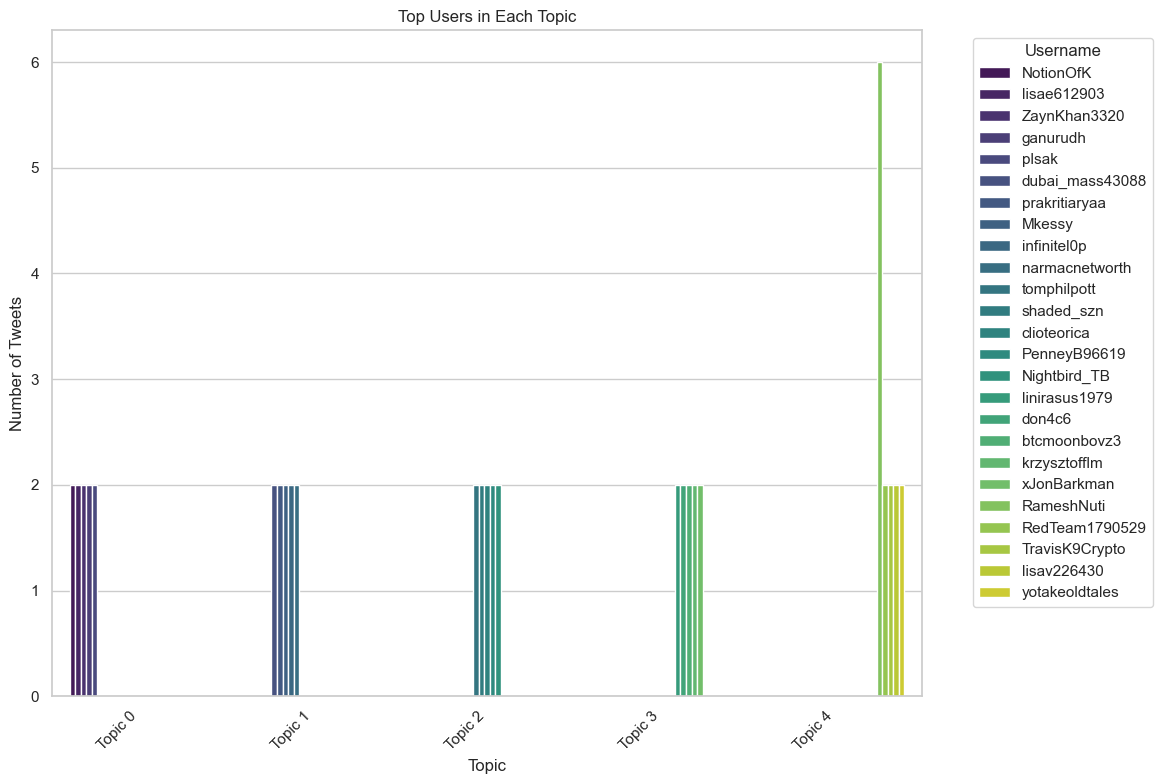

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")

visualization_data = []

for topic_num in range(5):
    top_users = tweets_df[tweets_df['topic'] == topic_num]['username'].value_counts().head(5)
    for username, count in top_users.items():
        visualization_data.append({'Topic': f'Topic {topic_num}', 'Username': username, 'Tweets': count})

viz_df = pd.DataFrame(visualization_data)

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Topic', y='Tweets', hue='Username', data=viz_df, palette='viridis')

plt.title('Top Users in Each Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')

barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.legend(title='Username', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


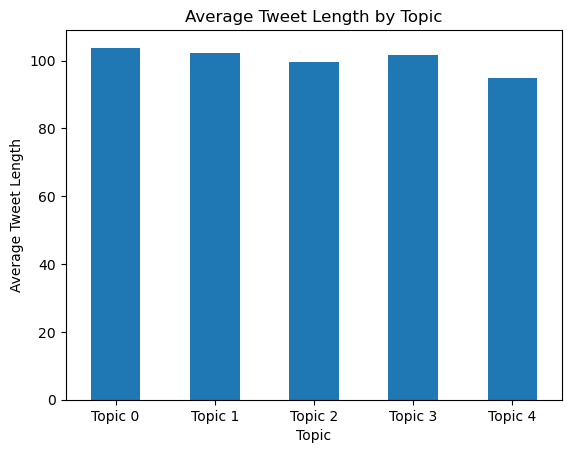

In [7]:
import matplotlib.pyplot as plt

tweets_df['tweet_length'] = tweets_df['text'].apply(len)

average_tweet_lengths = tweets_df.groupby('topic')['tweet_length'].mean()

average_tweet_lengths.plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Average Tweet Length')
plt.title('Average Tweet Length by Topic')
plt.xticks(range(5), ['Topic {}'.format(i) for i in range(5)], rotation=0)
plt.show()


In [8]:

import ast

tweets_df['public_metrics'] = tweets_df['public_metrics'].apply(ast.literal_eval)

tweets_df['reply_count'] = tweets_df['public_metrics'].apply(lambda x: x.get('reply_count', 0))
tweets_df['retweet_count'] = tweets_df['public_metrics'].apply(lambda x: x.get('retweet_count', 0))
tweets_df['like_count'] = tweets_df['public_metrics'].apply(lambda x: x.get('like_count', 0))

for topic_num in range(5):
    topic_df = tweets_df[tweets_df['topic'] == topic_num]
    avg_reply = topic_df['reply_count'].mean()
    avg_retweet = topic_df['retweet_count'].mean()
    avg_like = topic_df['like_count'].mean()
    print(f"Topic {topic_num} - Average Reply: {avg_reply}, Retweet: {avg_retweet}, Like: {avg_like}")


Topic 0 - Average Reply: 0.07563025210084033, Retweet: 1861.689075630252, Like: 0.12605042016806722
Topic 1 - Average Reply: 0.03597122302158273, Retweet: 200.41726618705036, Like: 0.19424460431654678
Topic 2 - Average Reply: 0.03355704697986577, Retweet: 928.3020134228188, Like: 0.04697986577181208
Topic 3 - Average Reply: 0.030303030303030304, Retweet: 136.86868686868686, Like: 0.050505050505050504
Topic 4 - Average Reply: 0.18562874251497005, Retweet: 2412.8502994011974, Like: 0.7485029940119761


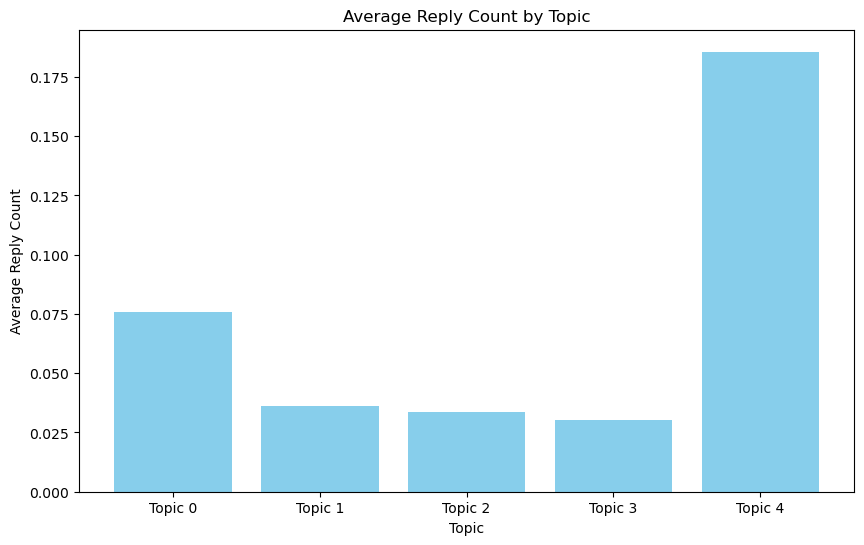

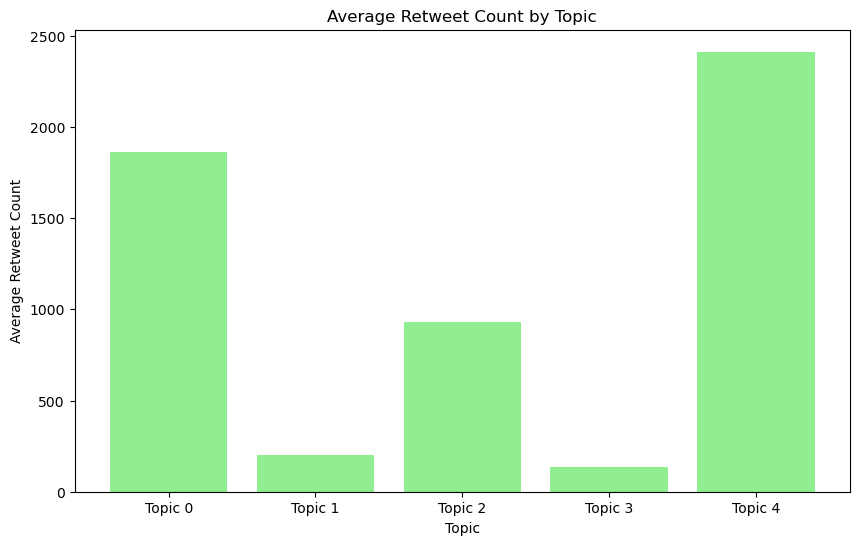

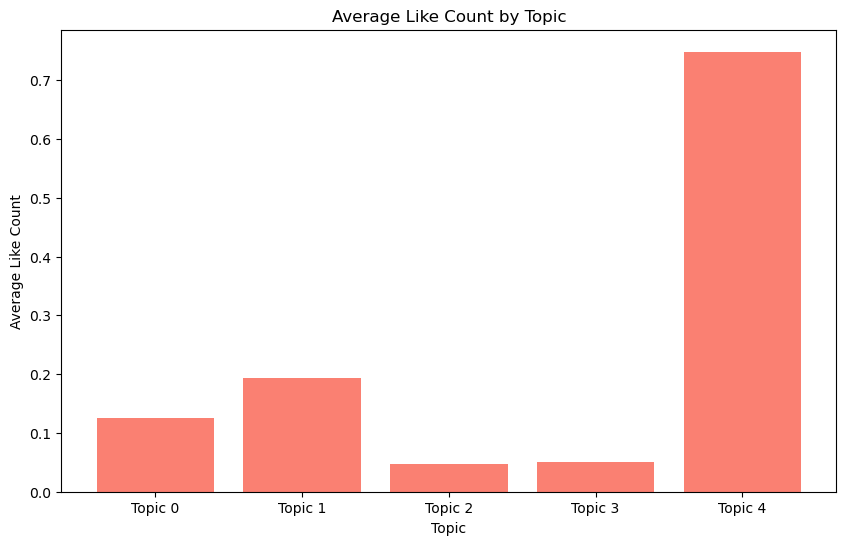

In [10]:
import matplotlib.pyplot as plt

average_reply = tweets_df.groupby('topic')['reply_count'].mean()
average_retweet = tweets_df.groupby('topic')['retweet_count'].mean()
average_like = tweets_df.groupby('topic')['like_count'].mean()

topics = ['Topic {}'.format(i) for i in range(5)]

plt.figure(figsize=(10, 6))
plt.bar(topics, average_reply, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Average Reply Count')
plt.title('Average Reply Count by Topic')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(topics, average_retweet, color='lightgreen')
plt.xlabel('Topic')
plt.ylabel('Average Retweet Count')
plt.title('Average Retweet Count by Topic')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(topics, average_like, color='salmon')
plt.xlabel('Topic')
plt.ylabel('Average Like Count')
plt.title('Average Like Count by Topic')
plt.show()

